In [1]:
import time
import numpy as np
import pandas as pd
from symmer.symplectic import random_PauliwordOp, PauliwordOp
from symmer.utils import random_symplectic_matrix, QubitOperator_to_dict

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(*obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

In [2]:
def symplectic_cleanup_1(symp_matrix, coeff_vec):
    """ Remove duplicated rows of symplectic matrix terms, whilst summing
    the corresponding coefficients of the deleted rows in coeff_vec
    """
    n_terms = symp_matrix.shape[0]
    # order lexicographically
    term_ordering = np.lexsort(symp_matrix.T)
    sorted_terms = symp_matrix[term_ordering]
    sorted_coeff = coeff_vec[term_ordering]
    # unique terms are those with non-zero entries in the adjacent row difference array
    diff_adjacent = np.diff(sorted_terms, axis=0)
    mask_unique_terms = np.array([True]+np.any(diff_adjacent, axis=1).tolist()) #faster than np.append!
    reduced_symp_matrix = sorted_terms[mask_unique_terms]
    # mask the term indices such that those which are skipped are summed under np.reduceat
    summing_indices = np.arange(n_terms)[mask_unique_terms]
    reduced_coeff_vec = np.add.reduceat(sorted_coeff, summing_indices, axis=0)
    
    return reduced_symp_matrix, reduced_coeff_vec

In [3]:
def symplectic_cleanup_2(symp_matrix, coeff_vec):
    reduced_symp_matrix, inverse = np.unique(symp_matrix, axis=0, return_inverse=True)
    sort = np.argsort(inverse)
    unique_indices, summing_indices = np.unique(inverse[sort], return_index=True)
    reduced_coeff_vec = np.add.reduceat(coeff_vec[sort], summing_indices, axis=0)
    
    return reduced_symp_matrix, reduced_coeff_vec

In [4]:
def symplectic_cleanup_3(symp_matrix, coeff_vec):
    # convert sym form to list of ints
    int_list = symp_matrix @ (1 << np.arange(symp_matrix.shape[1])[::-1])
    re_order_indices = np.argsort(int_list)
    sorted_int_list = int_list[re_order_indices]

    sorted_symp_matrix = symp_matrix[re_order_indices]
    sorted_coeff_vec = coeff_vec[re_order_indices]

    # determine the first indices of each element in the sorted list (and ignore duplicates)
    elements, indices = np.unique(sorted_int_list, return_counts=True)
    row_summing = np.append([0], np.cumsum(indices))[:-1]  # [0, index1, index2,...]

    # reduced_symplectic_matrix = np.add.reduceat(sorted_symp_matrix, row_summing, axis=0)
    reduced_symplectic_matrix = sorted_symp_matrix[row_summing]
    reduced_coeff_vec = np.add.reduceat(sorted_coeff_vec, row_summing, axis=0)

    return reduced_symplectic_matrix, reduced_coeff_vec

In [33]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)

def symplectic_cleanup_4(symp_matrix, coeff_vec):
    n_terms = symp_matrix.shape[0]
    # convert sym form to list of ints
    powers = [2**i for i in range(symp_matrix.shape[1])][::-1]
    int_list = [sum([powers[i] for i in np.where(t)[0].tolist()]) for t in symp_matrix]
    #int_list = [int(''.join(str(i) for i in row), base=2) for row in symp_matrix]
    re_order_indices = np.array(argsort(int_list))
    
    sorted_terms = symp_matrix[re_order_indices]
    sorted_coeff = coeff_vec[re_order_indices]
    
    # unique terms are those with non-zero entries in the adjacent row difference array
    diff_adjacent = np.diff(sorted_terms, axis=0)
    mask_unique_terms = np.array([True]+np.any(diff_adjacent, axis=1).tolist()) #faster than np.append!
    reduced_symp_matrix = sorted_terms[mask_unique_terms]
    # mask the term indices such that those which are skipped are summed under np.reduceat
    summing_indices = np.arange(n_terms)[mask_unique_terms]
    reduced_coeff_vec = np.add.reduceat(sorted_coeff, summing_indices, axis=0)
    
    return reduced_symp_matrix, reduced_coeff_vec

In [34]:
def multiplication(P,Q,cleanup_method):
    # multiplication is performed at the symplectic level, before being stacked and cleaned
    symp_stack, coeff_stack = zip(
        *[P._mul_symplectic(symp_vec=symp_vec, coeff=coeff, Y_count_in=Y_count+P.Y_count) 
        for symp_vec, coeff, Y_count in zip(Q.symp_matrix, Q.coeff_vec, Q.Y_count)]
    )
    return PauliwordOp(*cleanup_method(np.vstack(symp_stack), np.hstack(coeff_stack)))

In [35]:
symp_matrix = random_symplectic_matrix(5,5)
[int(''.join(str(i) for i in row), base=2) for row in symp_matrix]

[702, 731, 804, 522, 925]

In [38]:
Y_symp_lexsrt = {'10q':[], '100q':[], '1000q':[]}
Y_symp_unique = {'10q':[], '100q':[], '1000q':[]}
Y_symp_intmap1 = {'10q':[], '100q':[], '1000q':[]}
Y_symp_intmap2 = {'10q':[], '100q':[], '1000q':[]}
Y_open = {'10q':[], '100q':[], '1000q':[]}
Y_qisk = {'10q':[], '100q':[], '1000q':[]}

for n_q in [1000]:
    print(f'{n_q}-qubits')
    key = f'{n_q}q'
    for n_t in range(1, 100):
        if n_t%10==0:
            print(n_t)

        P_symr = random_PauliwordOp(n_q, n_t)
        P_qisk = P_symr.to_PauliSumOp
        #P_open = sum(P_symr.PauliwordOp_to_OF)
        
        Y_symp_lexsrt[key].append(runtime(multiplication,(P_symr,P_symr,symplectic_cleanup_1), n_samples=1))
        Y_symp_unique[key].append(runtime(multiplication,(P_symr,P_symr,symplectic_cleanup_2), n_samples=1))
        Y_symp_intmap1[key].append(runtime(multiplication,(P_symr,P_symr,symplectic_cleanup_3), n_samples=1))
        Y_symp_intmap2[key].append(runtime(multiplication,(P_symr,P_symr,symplectic_cleanup_4), n_samples=1))
        #Y_open[key].append(runtime(lambda x,y:x*y,(P_open,P_open), n_samples=1))
        Y_qisk[key].append(runtime(lambda x,y:x@y,(P_qisk,P_qisk), n_samples=1))

1000-qubits
10
20
30
40
50
60
70
80


KeyboardInterrupt: 

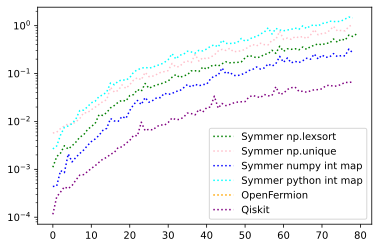

In [40]:
from matplotlib import pyplot as plt

lines = {'10q':'-', '100q':'--', '1000q':':'}

for n_q in ['1000q']:# ['10q', '100q', '1000q']:
    plt.plot(Y_symp_lexsrt[n_q], color='green', label='Symmer np.lexsort', ls = lines[n_q])
    plt.plot(Y_symp_unique[n_q], color='pink', label='Symmer np.unique', ls = lines[n_q])
    plt.plot(Y_symp_intmap1[n_q], color='blue', label='Symmer numpy int map', ls = lines[n_q])
    plt.plot(Y_symp_intmap2[n_q], color='cyan', label='Symmer python int map', ls = lines[n_q])
    plt.plot(Y_open[n_q], color='orange', label='OpenFermion', ls = lines[n_q])
    plt.plot(Y_qisk[n_q], color='purple', label='Qiskit', ls = lines[n_q])

plt.yscale('log')
plt.legend()